# Setup 

## Function Setup

In [16]:
import seaborn as sns
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statistics
import requests
import concurrent.futures
from collections import Counter
import json
import re
import re
import collections
from multiprocessing import Pool
from utilities.utils import *
import seaborn as sns

# get the seaborn color palette
current_palette = sns.color_palette()

# Define your color palette
palette = {"fake": current_palette[3], "real": current_palette[9]}  # red and green from the palette

In [17]:
def exploratory_stats(array, array_name):
    stats_list = []
    np_array = np.array(array, dtype=float)  # Ensure the array has a float dtype to handle NaNs

    mean = np.nanmean(np_array).round(2)
    median = np.nanmedian(np_array).round(2)
    min_value = np.nanmin(np_array).round(2)
    max_value = np.nanmax(np_array).round(2)
    std_dev = np.nanstd(np_array).round(2)
    q25 = np.nanpercentile(np_array, 25).round(2)
    q75 = np.nanpercentile(np_array, 75).round(2)

    stats_list.append([array_name, min_value, q25, mean, q75, max_value, median, std_dev])

    stats_df = pd.DataFrame(stats_list,
                            columns=[
                                'Article Category', 'Min', '1st Quantile', 'Mean', '3rd Quantile',
                                'Max', 'Median', 'Standard Deviation'
                            ])

    return stats_df
# define a function to read JSON file and return data
def read_json_file(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
    return data

def process_sentence(sentence):
    # Remove punctuation and digits
    sentence = re.sub(r'[^\w\s]', '', sentence)  # Remove punctuation
    sentence = re.sub(r'\d', '', sentence)  # Remove digits

    # Lowercase and split the sentence into words
    words = sentence.lower().split()

    return words


def top_words(sentences):
    # Initialize a list to hold all words
    all_words = []

    with Pool() as p:
        # Process sentences concurrently
        words_lists = p.map(process_sentence, sentences)

        # Add words to the list
        for words in words_lists:
            all_words.extend(words)

    # Use collections.Counter to get word frequencies
    word_counts = collections.Counter(all_words)

    # Get the top 25 words
    top_25_words = word_counts.most_common(25)

    # Calculate the total number of words
    total_words = len(all_words)

    # Convert the word counts to shares
    top_25_words_shares = [(word, count / total_words) for word, count in top_25_words]

    return top_25_words_shares


## Data Setup

In [15]:

# initialize an empty DataFrame
df = pd.DataFrame()

# specify the directory where JSON files are stored
dir_path = "data/data_files/fang-covid/articles/"
temp_df = pd.DataFrame()
source_arr = []
date_arr = []
article_arr = []
label_arr=[]
# loop over all JSON files in the directory
for filename in os.listdir(dir_path):
    if filename.endswith('.json'):
        full_filename = os.path.join(dir_path, filename)

        f = open(full_filename)
        single_fang = json.load(f)
        f.close()

        # append data to DataFrame
        source_arr.append(single_fang['source'])
        date_arr.append(single_fang['date'])
        article_arr.append(single_fang['article'])
        label_arr.append(single_fang['label'])

df['Publisher']=source_arr
df['Date']=date_arr
df['Article']=article_arr
df['Veracity']=label_arr
df['word_count'] = np.array(df['Article'].apply(lambda x: len(str(x).split())))
df['char_count'] = df['Article'].apply(lambda x: len(str(x)))



# Results

## Annotation info

In [18]:
transfer = pd.read_csv('data/data_files/transfer_data/thriple_annotator_702.csv')
print(transfer.value_counts('label'))
print(len(transfer))

label
1    431
0    358
Name: count, dtype: int64
789


## Sentence count Fang

In [19]:
df['text'] = df['Article'].apply(replace_abbreviations)
df['text'] = df['text'].apply(clean_special_characters)
df['sentence_count'] = df['text'].apply(lambda text: len(text.split('. ')))
total_sentences = df['sentence_count'].sum()
print(f"There are a total of {total_sentences} sentences in FANG-COVID")
print(f"Which leads to {total_sentences/len(df)} sentences per article")

There are a total of 1919177 sentences in FANG-COVID
Which leads to 46.53452790844285 sentences per article


# Word Count

In [20]:
df_word = np.array(df['Article'].apply(lambda x: len(str(x).split())))

# Character Count

### Exploratory stats

In [21]:
exploratory_stats(df['char_count'],'FANG')

,Article Category,Min,1st Quantile,Mean,3rd Quantile,Max,Median,Standard Deviation
0,FANG,297.0,2553.0,5648.03,6953.75,333426.0,4186.5,5972.67


## Boxplot

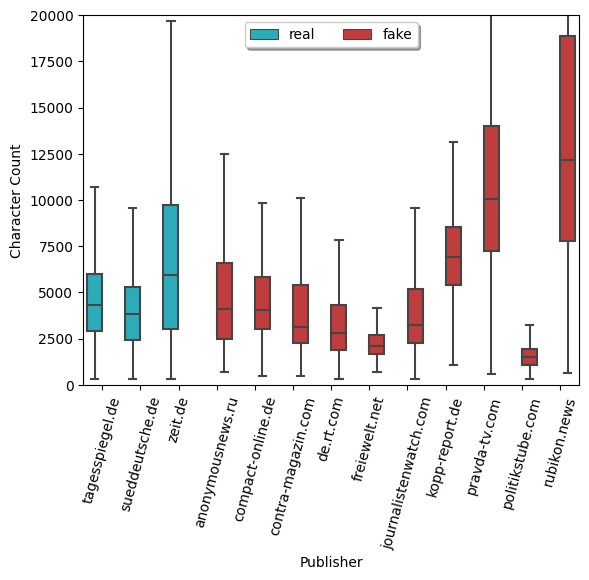

In [22]:
custom_order = [
    'tagesspiegel.de', 'sueddeutsche.de', 'zeit.de', 'anonymousnews.ru', 'compact-online.de',
    'contra-magazin.com', 'de.rt.com', 'freiewelt.net', 'journalistenwatch.com', 'kopp-report.de',
    'pravda-tv.com', 'politikstube.com', 'rubikon.news'
]

# Convert the 'category' column to a Categorical data type
df['Publisher'] = pd.Categorical(df['Publisher'], categories=custom_order, ordered=True)

# Sort the DataFrame based on your custom order
df = df.sort_values('Publisher')

ax = sns.boxplot(hue='Veracity',
                 y='char_count',
                 data=df,
                 x='Publisher',
                 showfliers=False,
                 palette=palette)

# Set plot title and labels
# plt.title('Word Count Distribution by Publisher')
plt.xlabel('Publisher')
plt.ylabel('Character Count')
# ax.set_yscale("log")
plt.xticks(rotation=75)
ax.set_ylim(-1,20000)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=3, fancybox=True, shadow=True)
# Show the plot
plt.show()

## Character / Word

In [23]:
article_charwords=np.nansum(df['char_count'])/np.nansum(df['word_count'])
print(article_charwords)


7.10293991907863
